In [288]:
pip install attention

In [289]:
pip install keras_tuner

# Environment Set-Up

Run the following code block in order to all install and import all the packages necessary for implementing HyDeLA and using to perfomr real time fault detection and diagnosis for cyber-physical systems. If the dataset is uploaded to google drive, then run the subseqeunt block as well, for mounting the drive to enable access to the dataset for training and testing. A detailed description of dataset is provided as well for better understanding what each value represents


In [327]:
import os
import re
import itertools
import numpy as np
import scipy.signal
import pandas as pd
import seaborn as sns
import scipy.io as scio
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, auc

from tensorflow import keras

from keras.layers import *
from keras import backend as k
from keras.optimizers import Adam
from keras.models import Sequential,Model,load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv1D, MaxPooling1D

from attention import Attention

In [291]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Once the dataset is imported, we can view the raw files in .csv format. There are three folders present within the ALL_DC_motor_Data folder following the naming convention Ua_{operating_voltage}V_Noise_2_perct. Data has been simulated for three operational conditions of the voltage source, namely 40V, 80V and 120V. Each folder further contains 8 files corresponding to 7 possible fault scenarios and 1 healthy state. The files cover include fault data pertainin to parameter as well as sensor faults under the following 2 cases.

*   **Individual Faults** - These correspond to faults in the current sensor I, angular velocity sensor W, DC motor constant K, electrical resistance Re and mechanical resistance Rm
*   **Simultaneous Faults** - These correspond to faults caused due to malfunction of either both the sensor I & W or both the resistances Re & Rm

Each fault file contains contains 12 columns which are briefly described as follows,


*   **time** - contains timestamps for data during the time duration of 500s to 3000s sampled at an interval of 0.1s
*   **Im** - contains the measurement of the current sensor at the particular timestamp
*   **Wm** - contains the measurement of the current sensor at the particular timestamp em
*   **ARR1** - contains the residual value obtained by numerical evaluation of the contsraint associated with the electrical part (r1)
*  ** ARR2** - contains the residual value obtained by numerical evaluation of the contsraint associated with the mechanical part (r2)
*   **a1_upper & a1_lower** - contain the adaptive thresholds corresponding to r1 and both are just conjugates of one another i.e., add up to zero
*   **a2_upper & a2_lower** - contain the adaptive thresholds corresponding to r2 and both are just conjugates of one another i.e., add up to zero
*   **activation_arr1** - this column contains a 1 when r1 exceeds either one of its thresholds i.e., a1_upper or a1_lower, otherwise 0
*   **activation_arr2** - this column contains a 1 when r2 exceeds either one of its thresholds i.e., a2_upper or a2_lower, otherwise 0
*   **Fault_type** - as is indicated by the name, this corresponds to actual fault introduced and serves as a label for the data making it a supervision classification task

# Data Visualization

Before proceeding to carry out data preprocessing, we shall have visualize data with would provide greater insights and understanding of the dataset. In order to achieve, we first plot the variation of residual signal with time (which corresponds to TABLE VII of the paper) and then also plot the measurement of the current and angular velocity sensors with time

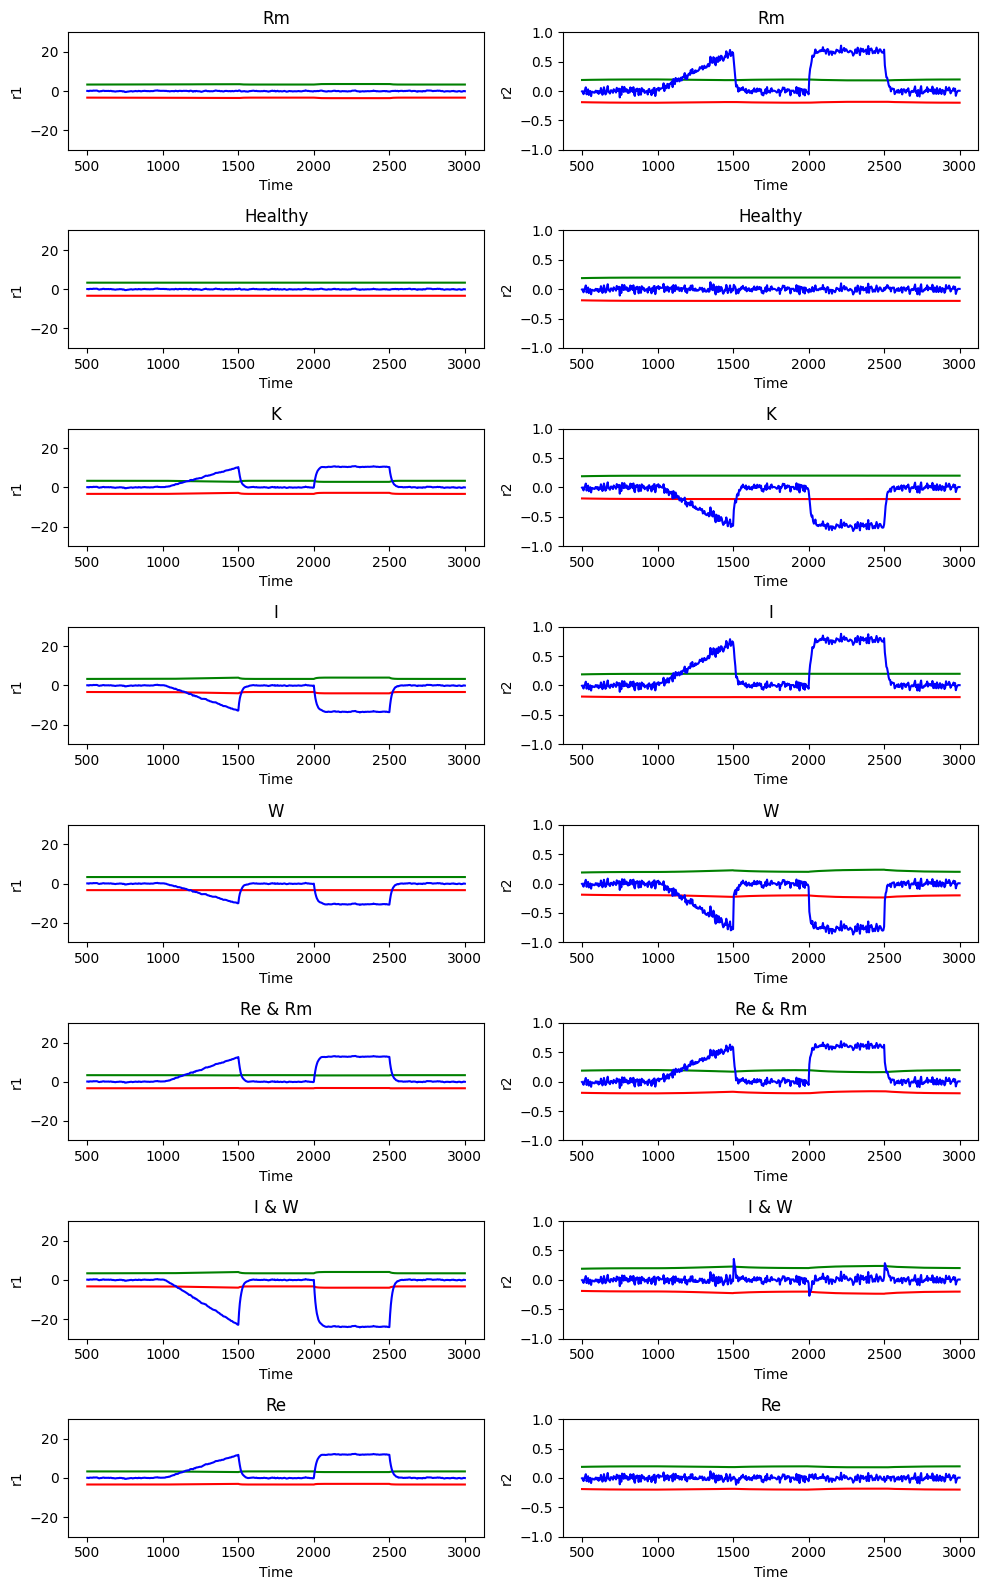

In [292]:
working_cond = 40 #this corresponds to possible values under which the voltage source operates i.e., 40, 80 and 120

Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_120V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
file_name = os.listdir(path=Path) # List of all the files in the folder
fig, axs = plt.subplots(len(file_name), 2, figsize=(10, 2 * len(file_name)))

for i, file in enumerate(file_name):
    csv_path = os.path.join(Path, file) # Obtains the exact path for that file
    df = pd.read_csv(csv_path)  # saves that Fault data in a dummy variable "df"
    df = df.iloc[::50]
    ax1 = axs[i][0]
    ax2 = axs[i][1]
    ax1.plot(df['time'], df['a1_lower'], '-r', label='')
    ax2.plot(df['time'], df['a2_lower'], '-r', label='')
    ax1.plot(df['time'], df['a1_upper'], '-g', label='a1')
    ax2.plot(df['time'], df['a2_upper'], '-g', label='a2')
    ax1.plot(df['time'], df['ARR1'], '-b', label='')
    ax2.plot(df['time'], df['ARR2'], '-b', label='')
    ax1.set_title(file[:-13]) #to extract only the fault type from the name of fault file, _noise_02.csv contains 13 characters
    ax1.set_ylim(-30, 30)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('r1')
    ax2.set_title(file[:-13])
    ax2.set_ylim(-1, 1)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('r2')

plt.tight_layout()
plt.show()

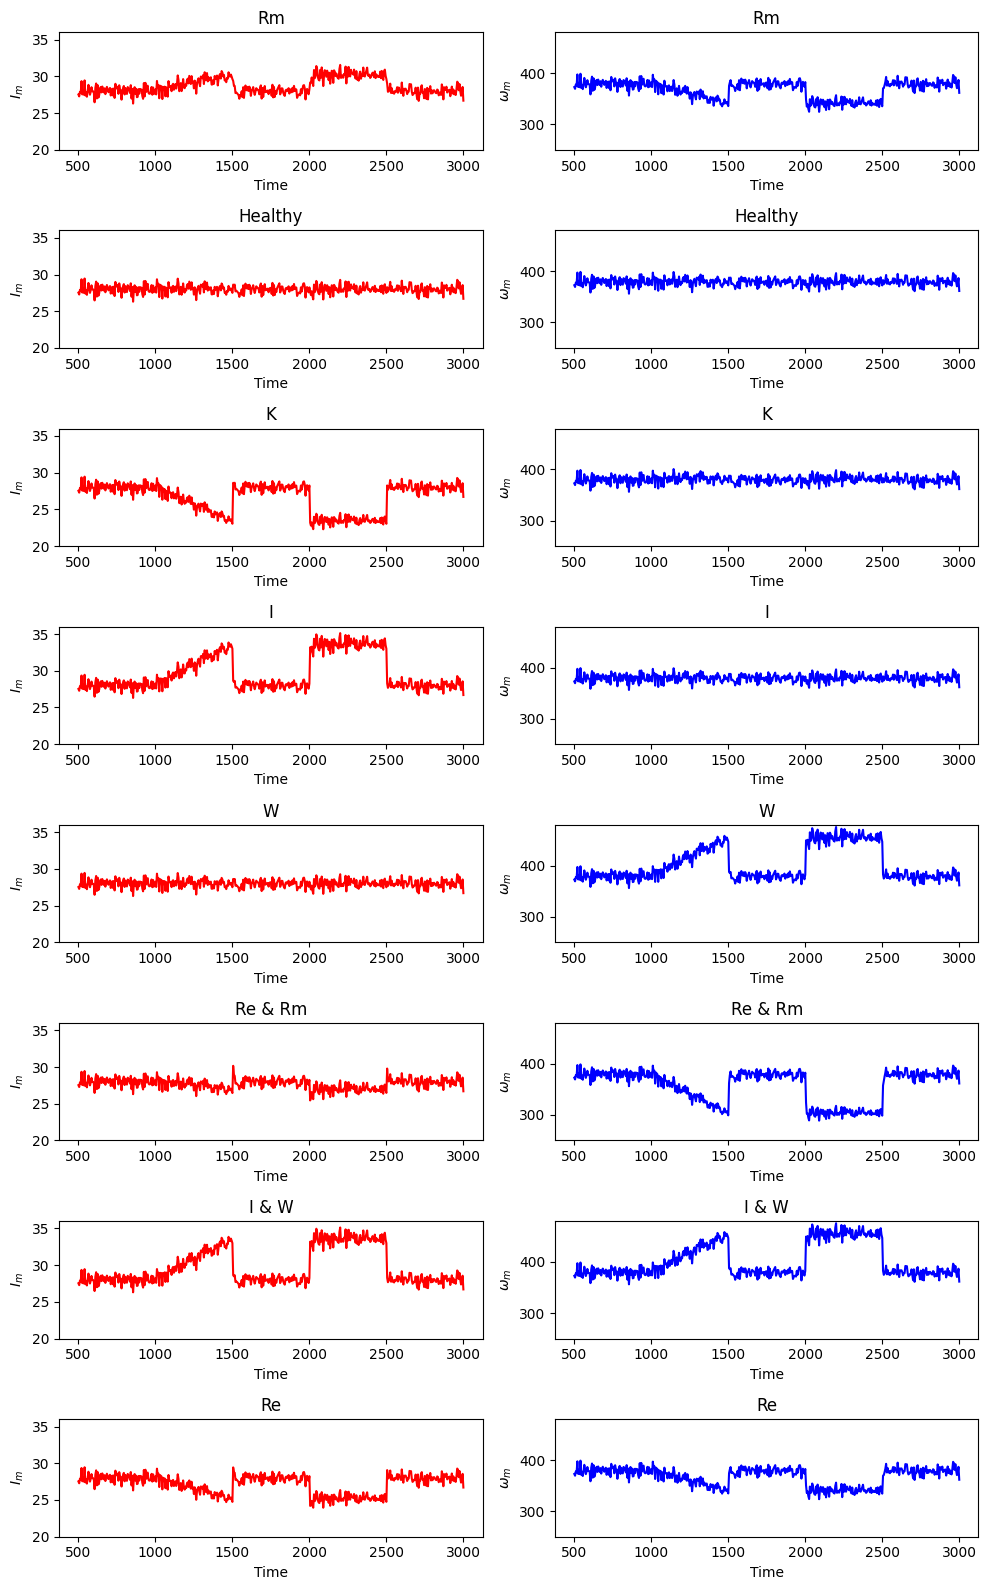

In [293]:
Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_120V_Noise_2_perct'.format(40) # Path of the folder containing CSV files from that working condition
file_name = os.listdir(path=Path) # List of all the files in the folder

fig, axs = plt.subplots(len(file_name), 2, figsize=(10, 2 * len(file_name)))

for i, file in enumerate(file_name):
    csv_path = os.path.join(Path, file)
    df = pd.read_csv(csv_path)
    df = df.iloc[::50]
    ax1 = axs[i][0]
    ax2 = axs[i][1]
    ax1.plot(df['time'], df['Im'], '-r', label='')
    ax2.plot(df['time'], df['Wm'], '-b', label='')
    ax1.set_title(file[:-13])
    ax1.set_ylim(20, 36)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('$I_m$')
    ax2.set_title(file[:-13])
    ax2.set_ylim(250, 480)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('$\omega_m$')

plt.tight_layout()
plt.show()

# Dataframe Creation

Each fault file contains two type of faults -

*   **Incipient** (gradually increases with time) introduced during the interval 1000s - 1500s
*   **Step** (instantaneous fluctuation) introduced during the interval 2000s - 2500s

We hence now aim at creating dataframe which contains only the residual values during the above two-mentioned time intervals for all working conditions of the voltage source thereby containing only the relevant fault data. Subsequently, two more code blocks are included for visualtion purpose of the reader. The first plot represents the variation of angular velocity sensor reading with that of the current sensor. The second plot (corresponds to Fig 9. in the paper) shows the variation of the one residual signal with the other for all fault types. From the plot, we can see the distribution of each fault in residual space is unique.


In [294]:
def obtain_DataFrame_for_this_working_condition(working_cond):
    # Input = "Working Condition" [40V, 80V, 120V]
    # Output = "A dataFrame contaning all fault scnerio from that Working Condition"
    # The DataFrame has following columns [time, I, W, ARR1, ARR2, a1_upper,  a1_lower, a2_upper,  a2_lower,  activation_arr1,  activation_arr2 FaultClass] for the given "working_cond"

    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path) # List of all the files in the folder

    DF = pd.DataFrame() # Initialize an empty DataFrame

    for f in file_name : #Iterate through each file, which coresponds to a Fault

        csv_path =  os.path.join(Path,f) #Obtains the exact path for that file

        df = pd.read_csv(csv_path) #saves that Fault data in a dummy variable "df"


        temp1=df[(df.time > 1050) & (df.time< 1500)]  # Incipient Faults -----Taking samples after which the fault was introduced

        temp2=df[(df.time > 2050) & (df.time< 2500)]  # Step Faults-----------Taking samples after which the fault was introduced

        df=pd.concat([temp1,temp2])                  #Concatinate both Incipient and Step Fault

        DF=pd.concat([DF,df])                        # Append the "f"-Fault to the new dataframe DF

    DF['Working_cond'] = np.repeat('U-{}V'.format(working_cond), len(DF))
    return DF



In [295]:
df_120 = obtain_DataFrame_for_this_working_condition(working_cond=120)
df_40 = obtain_DataFrame_for_this_working_condition(working_cond=40)
df_80 = obtain_DataFrame_for_this_working_condition(working_cond=80)

DF = pd.concat([df_40,df_80,df_120]) # ALL 3 working conditions are saved in one DataFRame

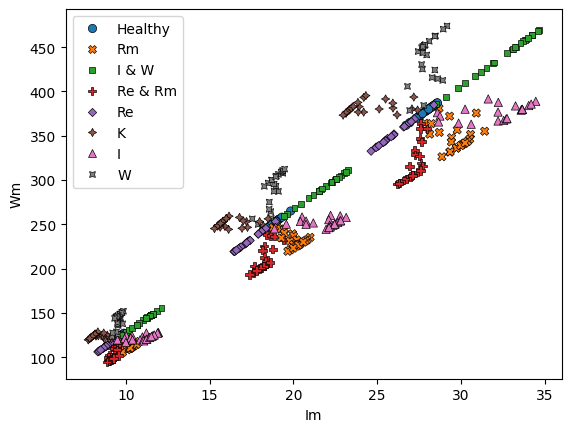

In [296]:
sns.scatterplot(data=DF.iloc[::400,:],x='Im',y='Wm',hue='Fault_type',style='Fault_type',edgecolor='black')
plt.legend()
plt.show()

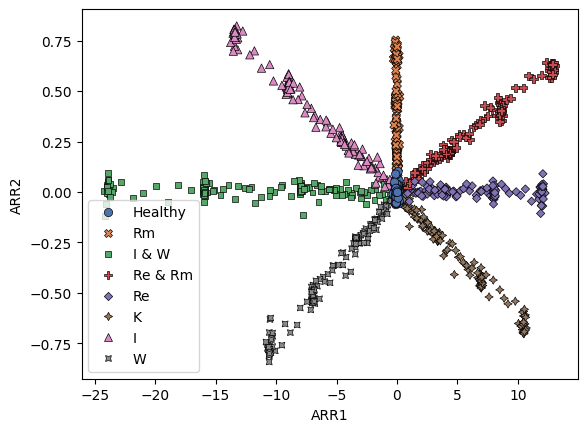

In [297]:
sns.scatterplot(data=DF.iloc[::200,:],x='ARR1',y='ARR2',style='Fault_type',hue='Fault_type', palette = 'deep', edgecolor = 'black')
plt.legend()
plt.show()

# Data Augmentation

The following code block performs data augmentation of the residual signal data by stacking vertically the resulting 1 dimensional signals so as to create a mutti-variate time series signal and then applying **sliding window processing** with user-determined values for the hyper-parameters (stride S and window length WL)

In [298]:
def Sliding_Window(df_temp, win_len, stride):
    """
    Sliding window function for data segmentation and label extraction.

    Args:
        df_temp (DataFrame): Input dataframe containing the data.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X (ndarray): Segmented input sequences.
        Y (ndarray): Extracted output labels.
        T (ndarray): Corresponding timestamps.
    """
    X = []  # List to store segmented input sequences.
    Y = []  # List to store extracted output labels.
    T = []  # List to store corresponding timestamps.

    # Loop through the dataframe with the specified stride.
    for i in np.arange(0, len(df_temp) - win_len, stride):
        # Extract a subset of the dataframe based on the window length.
        temp = df_temp.iloc[i:i + win_len, [3, 4]].values

        # Append the segmented input sequence to the X list.
        X.append(temp)

        # Append the output label at the end of the window to the Y list.
        Y.append(df_temp.iloc[i + win_len, -1])

        # Append the timestamp at the end of the window to the T list.
        T.append(df_temp.iloc[i + win_len, 0])

    return np.array(X), np.array(Y), np.array(T)

# Data Preprocessing

Once the augmented data from the previous step is available, we now need to preprocess the data to extract the input sequences and label, followed by appropriately splitting the data into train and test sets for model training

In [299]:
def PreprocessData(working_cond, win_len, stride):
    """
    Preprocessing function to extract input sequences and output labels from CSV files of a specific working condition.

    Args:
        working_cond (str): Working condition identifier used to locate the folder containing CSV files.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X_full (ndarray): Concatenated segmented input sequences.
        Y_full (ndarray): Concatenated output labels.
    """

    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)
    file_name = os.listdir(path=Path)

    X_full, Y_full = [], []  # Lists to store concatenated segmented input sequences and output labels

    for f in file_name:  # Iterate through each file, which corresponds to a fault
        csv_path = os.path.join(Path, f)
        df = pd.read_csv(csv_path)

        temp_df_1 = df[(df.time > 1050) & (df.time < 1500)]  # Incipient - Taking samples after which the parameter fault was introduced
        x1, y1, _ = Sliding_Window(temp_df_1, win_len, stride)

        temp_df_2 = df[(df.time > 2050) & (df.time < 2500)]  # Step - Taking samples after which the parameter fault was introduced
        x2, y2, _ = Sliding_Window(temp_df_2, win_len, stride)

        x_temp, y_temp = np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2), axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)

    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1, X_full.shape[2], X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [300]:
WL=20 # can be used for adjusting window length
S=40 # can be used for adjusting stride

# Preprocess data for working condition 120
X_120, Y_120 = PreprocessData(working_cond=120, win_len=WL, stride=S)

# Preprocess data for working condition 80
X_80, Y_80 = PreprocessData(working_cond=80, win_len=WL, stride=S)

# Preprocess data for working condition 40
X_40, Y_40 = PreprocessData(working_cond=40, win_len=WL, stride=S)

# Concatenate the preprocessed data from different working conditions
X_full = np.concatenate((X_40, X_80, X_120))
Y_full = np.concatenate((Y_40, Y_80, Y_120))

In [301]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, train_size=256, random_state=42)

# Standardising the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

# One Hot encoding
encoder = OneHotEncoder(sparse_output=False) # in case of error, add the argument handle_unknown = 'ignore'

y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))

# Model Architecture

The following code blocks defines the model by sepcifying explicitly all the layer details. The convolution network component is simple and uses a single convolutional layer followed by max-pooling. The subsequent LSTM network consists of 3 layers with dropout regularization applied to the first and last layers to avoid overfitting. This is then followed by the attention layer after which the output is flattened and sent through a fully connected layer before finally reaching ultimate classification layer, the output of which determines the fault type. Note that for adding the Attention layer, it may be necessary to first install the attention pack

The first two code blocks are used for fine-tuning of hyper-parameters wherein a specified set of values for the hyper-parameters is given beforehand and then the best set in terms of validation accuracy is chosen for further analysis. However, this might be quite a time and pain-staking process. Hence, for user convenience these two block can be safely skipped and the third block can be directly run which defines the model with hyper-paramaeter values, we found were the best during our research. Make sure that the other block would be commented while executing this.

In [302]:
def build_model(hp):

    num_classes=len(encoder.categories_[0])

    # create model object
    model = Sequential([
    Conv1D(filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=32), kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]), padding='same'),
    MaxPooling1D(pool_size=2,padding='same'),
    LSTM(units=hp.Int('lstm_1', min_value=16, max_value=128, step=32), return_sequences=True),
    Dropout(0.2),
    LSTM(units=hp.Int('lstm_2', min_value=16, max_value=128, step=32), return_sequences=True),
    LSTM(units=hp.Int('lstm_3', min_value=16, max_value=128, step=32), return_sequences=True),
    Dropout(0.5),
    Attention(),
    Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16), activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [303]:
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials = 10) #creating randomsearch object
tuner.search(X_train_sc,y_train_ohe,epochs=20,validation_data=(X_test_sc,y_test_ohe)) # search best parameter values
HyDeLA_model_tuned=tuner.get_best_models(num_models=1)[0]
HyDeLA_model_tuned.summary()

In [304]:
def HYDELA_model(encoder,X_train_transformed):
    num_classes=len(encoder.categories_[0])

    HyDeLA_model = Sequential()
    HyDeLA_model.add(Conv1D(16, kernel_size=(5),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    HyDeLA_model.add(MaxPooling1D((2),padding='same'))
    HyDeLA_model.add(LSTM(112, return_sequences=True))
    HyDeLA_model.add(Dropout(0.2))
    HyDeLA_model.add(LSTM(16,return_sequences=True))
    HyDeLA_model.add(LSTM(48,return_sequences=True))
    HyDeLA_model.add(Dropout(0.5))
    HyDeLA_model.add(Attention())
    HyDeLA_model.add(Flatten())
    HyDeLA_model.add(Dense(64, activation='relu'))
    HyDeLA_model.add(Dense(num_classes, activation='softmax'))

    HyDeLA_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

    return HyDeLA_model

# Model Training

Once we have defined the model architecture from the previous code blocks (either by fine-tuning or existing framework), we now proceed towards training the model, which is performed by the following code block. The subsequent block gives the plot (corresponding to Fig 8 in the paper) of validation and training loss versus number of epochs.

In [305]:
# Define an EarlyStopping callback to monitor validation accuracy and restore best weights
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create a model using the specified encoder and X_train_sc
hydela_model = HYDELA_model(encoder, X_train_sc)

# Train the model
history = hydela_model.fit(X_train_sc, y_train_ohe, epochs=200, batch_size=16, validation_data=(X_test_sc, y_test_ohe), callbacks=[callback], shuffle=False, verbose=1)

Epoch 1/200
16/16 [==============================] - 10s 239ms/step - loss: 1.9869 - accuracy: 0.2383 - val_loss: 1.7554 - val_accuracy: 0.2434
Epoch 2/200
16/16 [==============================] - 3s 188ms/step - loss: 1.4430 - accuracy: 0.4219 - val_loss: 1.0239 - val_accuracy: 0.6908
Epoch 3/200
16/16 [==============================] - 3s 188ms/step - loss: 0.7705 - accuracy: 0.7539 - val_loss: 0.5667 - val_accuracy: 0.7443
Epoch 4/200
16/16 [==============================] - 3s 189ms/step - loss: 0.5139 - accuracy: 0.7461 - val_loss: 0.4054 - val_accuracy: 0.7586
Epoch 5/200
16/16 [==============================] - 3s 198ms/step - loss: 0.3580 - accuracy: 0.8906 - val_loss: 0.2279 - val_accuracy: 0.9840
Epoch 6/200
16/16 [==============================] - 2s 136ms/step - loss: 0.2027 - accuracy: 0.9805 - val_loss: 0.1110 - val_accuracy: 0.9826
Epoch 7/200
16/16 [==============================] - 3s 187ms/step - loss: 0.1001 - accuracy: 0.9805 - val_loss: 0.0717 - val_accuracy: 0.983

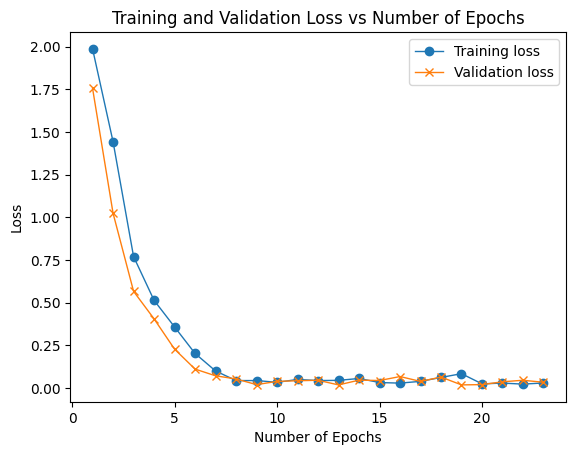

In [306]:
# Access the loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training loss', marker = 'o', lw = 1)
plt.plot(epochs, validation_loss, label='Validation loss', marker = 'x', lw = 1)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Number of Epochs')
plt.legend()
plt.show()

# Model Evaluation

Once the trained model is available, we will now use to make predictions on the test data and evaluate its perfomance using 4 metrics - namely F1-score, accuracy, precision and recall. Confusion matrix can also be plotted using the predciteions and true values.

In [307]:
# Perform prediction using the CNN model on the scaled test data
y_pred = hydela_model.predict(X_test_sc)

# Inverse transform the predicted labels using the encoder
y_pred = encoder.inverse_transform(y_pred)

# Calculate and print precision, recall, F1-score and accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Training Sample Size = {len(X_train)}, F1 score is - {f1}")
print(f"Training Sample Size = {len(X_train)}, Accuracy is - {accuracy}")
print(f"Training Sample Size = {len(X_train)}, Precision is - {precision}")
print(f"Training Sample Size = {len(X_train)}, Recall is - {recall}")

160/160 [==============================] - 3s 8ms/step
Training Sample Size = 256, F1 score is - 0.9947349330945912
Training Sample Size = 256, Accuracy is - 0.9947265625
Training Sample Size = 256, Precision is - 0.9947711101749215
Training Sample Size = 256, Recall is - 0.9947265625


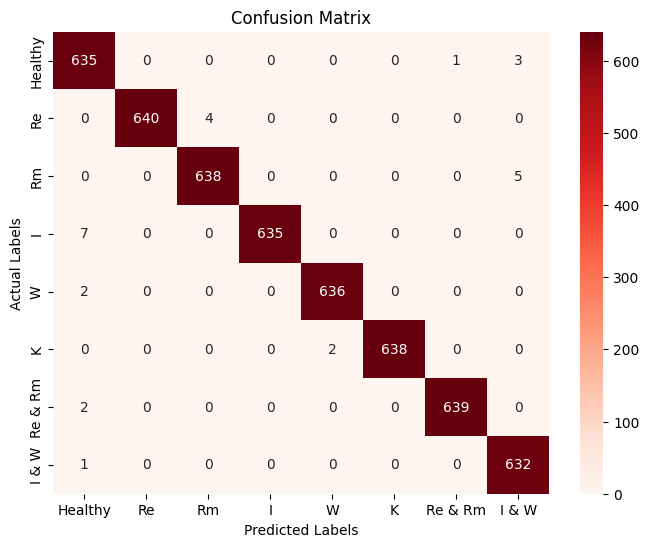

In [308]:
# Define the class labels
class_labels = ['Healthy', 'Re', 'Rm', 'I', 'W', 'K', 'Re & Rm', 'I & W']

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [309]:
def lab_to_num(value):
  """
  lab_to_num converts the literal labels to numeric labels as per the mapping function label_mapping = {'Re': 1, 'Rm': 2, 'I': 3, 'W': 4, 'K': 5, 'I & W': 7, 'Re & Rm': 6}
  parameter : value is assumed to be numpy.ndarray()
  """
  for i in range(len(value)):
    if value[i]=='Re':
      value[i]=1
    elif value[i]=='Rm':
      value[i]=2
    elif value[i]=='I':
      value[i]=3
    elif value[i]=='W':
      value[i]=4
    elif value[i]=='K':
      value[i]=5
    elif value[i]=='I & W':
      value[i]=7
    elif value[i]=='Re & Rm':
      value[i]=6
    else:
      value[i]=0

  return value

In [310]:
num_label = ['1', '2', '3', '4', '5', '6', '7']

test_roc = []
pred_roc = []

test_roc = [1 if label in num_label else 0 for label in lab_to_num(y_test)]
pred_roc = [1 if label in num_label else 0 for label in lab_to_num(y_pred)]

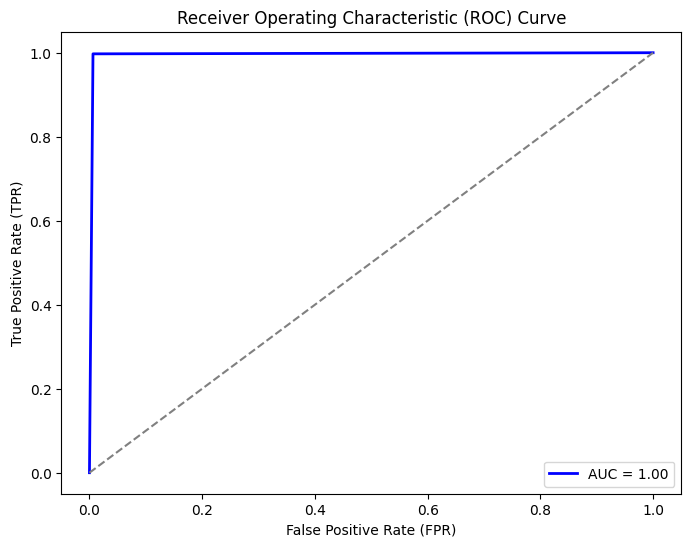

In [311]:
# Compute ROC curve
fpr, tpr, threshold = roc_curve(test_roc, pred_roc)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Online FDD

We shall now use the trained HyDeLA model to perform fault detection and diagnosis in real-time scenarios, where in the input would be arriving continuously in a stream of time-packets. The following code blocks also plot the results as well, in which case the region highlited by red indicates the actual fault duration, the blue line represents the predicted fault type while the actual fault type is depicted in the top right corner of the plot.

In [312]:
fault_label_dict = {'Healthy': 0, 'I': 3, 'I & W': 7, 'K': 5, 'Re': 1, 'Re & Rm': 6, 'Rm': 2, 'W': 4}

In [313]:
def Predict_HYDELA(fault_file,working_cond, HyDeLA_model, scaler, encoder, WL, S):
    """
    Predict fault labels using a trained CNN model.

    Args:
        fault_file (str): Name of the fault file to predict labels for.
        cnn_model (Model): Trained CNN model for fault prediction.
        scaler (Scaler): Scaler object for data normalization.
        encoder (Encoder): Encoder object for label encoding.
        WL (int): Length of the sliding window.
        S (int): Stride or step size for sliding the window.

    Returns:
        y_pred_num (ndarray): Predicted fault labels in numerical format.
        y_true_num (ndarray): True fault labels in numerical format.
        t1 (ndarray): Corresponding timestamps.
    """
    # Construct the path to the fault file
    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)
    csv_path = os.path.join(Path, fault_file)
    df = pd.read_csv(csv_path)

    # Perform sliding window operation on the data
    x1, y1, t1 = Sliding_Window(df, win_len=WL, stride=S)

    # Normalize the input data using the provided scaler
    x_sc = scaler.transform(x1.reshape(-1, x1.shape[-1])).reshape(x1.shape)

    # Make predictions using the HyDeLA model
    y_pred = HyDeLA_model.predict(x_sc)
    y_pred = encoder.inverse_transform(y_pred)

    # Convert the predicted labels to numerical format
    y_pred_num = np.vectorize(fault_label_dict.get)(y_pred)
    y_pred_num = y_pred_num.reshape(-1)

    # Convert the true labels to numerical format
    y_true_num = np.vectorize(fault_label_dict.get)(y1)
    y_true_num = y_true_num.reshape(-1)

    return y_pred_num, y_true_num, t1

In [314]:
def plot_online_FDI(y_pred_num, y_true_num, t1,Title):
    """
    Function to plot online fault detection and identification (FDI) results.

    Args:
        y_pred_num (ndarray): Predicted fault class values.
        y_true_num (ndarray): Actual fault class values.
        t1 (ndarray): Time values.

    Returns:
        None (displays the plot).
    """
    plt.subplots(figsize=(8, 3))

    sns.scatterplot(x=t1, y=y_pred_num, hue=y_true_num, palette="bright", edgecolor='black', alpha=0.5, s=30)

    # Add labels and title
    plt.xlabel('time (s)', fontsize=10)
    plt.ylabel('Predicted fault class', fontsize=10)

    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7])
    plt.ylim([-.5, 7.5])
    plt.legend(markerscale=1.5, bbox_to_anchor=(1.01, 1.05), title='Actual fault class', fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.axvspan(xmin=1000, xmax=1500, facecolor='r', alpha=0.2)
    plt.axvspan(xmin=2000, xmax=2500, facecolor='r', alpha=0.2)
    plt.title(Title)
    # Display the plot
    plt.show()

Introduced fault is Healthy
20/20 [==============================] - 1s 6ms/step


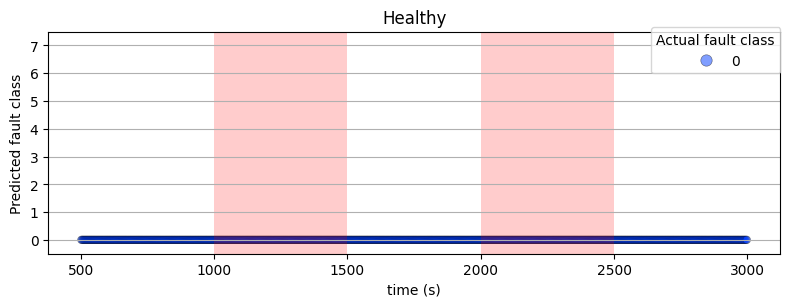

Introduced fault is I & W
20/20 [==============================] - 0s 7ms/step


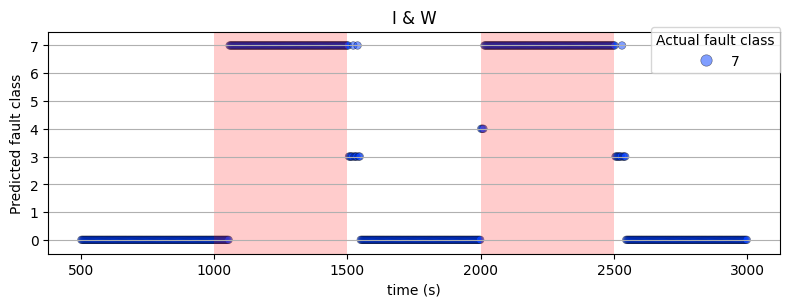

Introduced fault is I
20/20 [==============================] - 0s 7ms/step


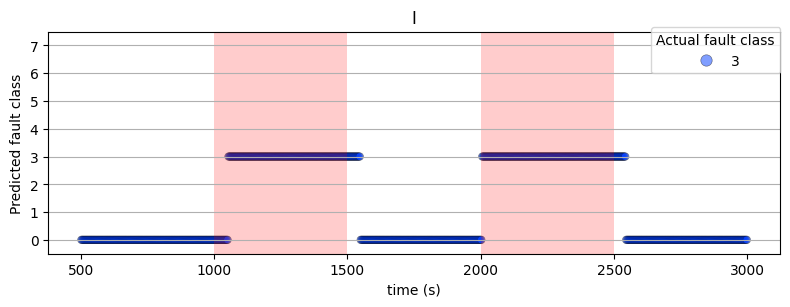

Introduced fault is K
20/20 [==============================] - 0s 7ms/step


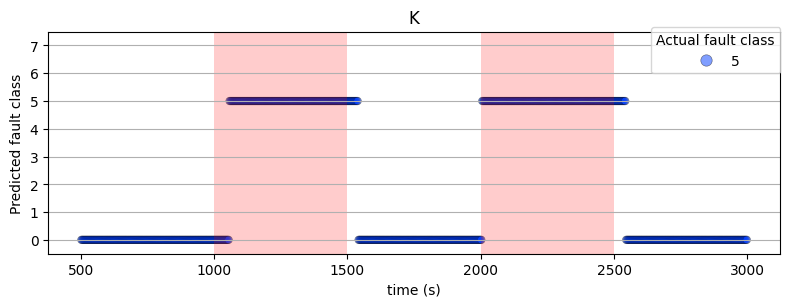

Introduced fault is Re & Rm
20/20 [==============================] - 0s 7ms/step


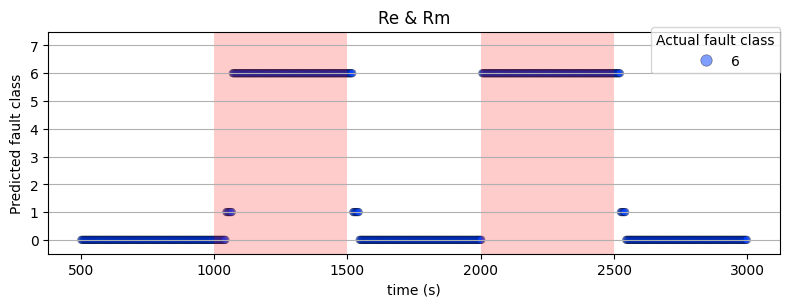

Introduced fault is Re
20/20 [==============================] - 0s 7ms/step


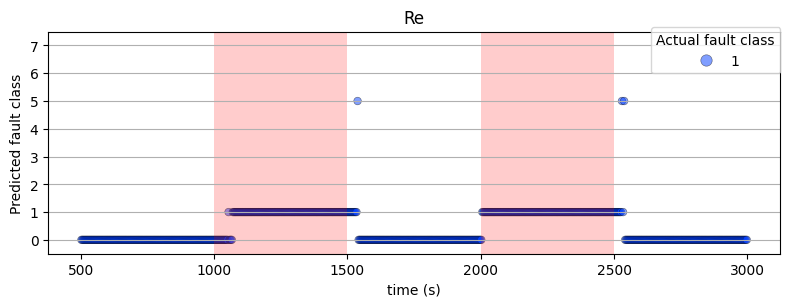

Introduced fault is Rm
20/20 [==============================] - 0s 7ms/step


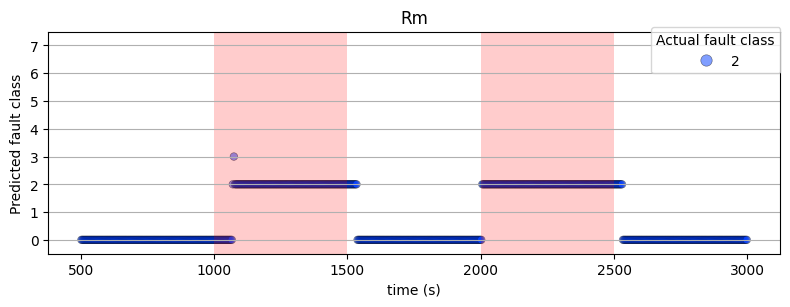

Introduced fault is W
20/20 [==============================] - 0s 9ms/step


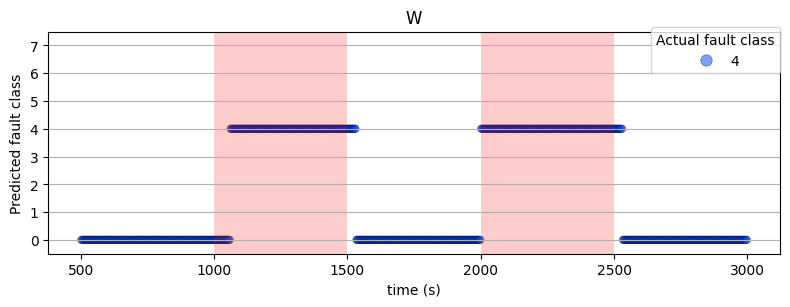

In [315]:
file_name = ['Healthy_noise_02.csv',
            'I & W_noise_02.csv',
            'I_noise_02.csv',
            'K_noise_02.csv',
            'Re & Rm_noise_02.csv',
            'Re_noise_02.csv',
            'Rm_noise_02.csv',
            'W_noise_02.csv']

for f in file_name:
    # Extract the fault type from the file name
    fault_type = f[:-13]

    print(f"Introduced fault is {fault_type}")

    # Perform fault diagnosis using the trained HyDeLA model
    y_pred_num, y_true_num, t1 = Predict_HYDELA(fault_file=f, working_cond=40, HyDeLA_model=HyDeLA_model, scaler=scaler, encoder=encoder, WL=WL, S=S)

    # Plot online fault detection and isolation results
    plot_online_FDI(y_pred_num, y_true_num, t1,Title=fault_type)

# Comparison Schemes

The following code blocks now deploy other models such as BG-CNN and default version of support vector machine (SVM), k-Nearest Neighbours (KNN), vanilla artificial neural network (ANN), convolutional neural network (CNN) and random forest (RF). The fault detection ability is also measured by using area under receiver operating characteristic curve (AUC)

In [316]:
fault_label_dict = {'Healthy':0, 'Re':1, 'Rm':2, 'I':3, 'W':4, 'K':5,  'Re & Rm':6, 'I & W':7}

Y_full = np.vectorize(fault_label_dict.get)(Y_full)

In [317]:
def n_samples_per_class(X_sc,Y,num_samples):
    """
    Function to sample a specified number of data points per class.

    Args:
        X_sc (ndarray): Input data array.
        Y (ndarray): Label array.
        num_samples (int): Number of samples to be selected per class.

    Returns:
        x_sample (ndarray): Sampled input data.
        y_sample (ndarray): Sampled labels.
    """
    from sklearn.utils import resample

    if len(X_sc.shape)==3:
        # Initialize empty arrays for the sampled data
        x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1], X_sc.shape[2]))
    else:
        x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1]))
    y_sample = np.zeros(num_samples * np.unique(Y).size)

    # Loop over each class label and sample from the corresponding data points
    for i, label in enumerate(np.unique(Y)):
        class_indices = np.where(Y == label)[0]
        sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
        x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
        y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]

    return x_sample,y_sample

In [318]:
def Scale_Encode(X_full,Y_full, num_training_samples):
    # Train Test split
    X_train,y_train=n_samples_per_class(X_full,Y_full,num_samples=num_training_samples)
    X_test,y_test = X_full, Y_full

    # Standardising the data
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    # One Hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
    y_test_ohe = encoder.transform(y_test.reshape(-1,1))

    return X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder

In [323]:
def CNN_model(encoder,X_train_transformed):
    # Hyperparameters obtained aftre tuning
    num_k1=112
    k1 = 5
    num_d1=96
    alpha = 0.001

    num_classes=len(encoder.categories_[0])

    cnn_model = Sequential()
    cnn_model.add(Conv1D(num_k1, kernel_size=(k1),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    cnn_model.add(MaxPooling1D((2),padding='same'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(num_d1, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),metrics=['accuracy'])

    return cnn_model

In [348]:
f1_BG = []  # List to store F1 scores of the BG-CNN model

# Iterate over different values of N
for N in [16, 32, 64, 128, 256, 512]:
    print(f'Experiment for N = {N}')

    # Scale, encode, and split the data into training and testing sets
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full, Y_full, num_training_samples=N)

    # Create and train the CNN model
    cnn_model = CNN_model(encoder, X_train_sc)
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
    cnn_model.fit(X_train_sc, y_train_ohe, epochs=200, batch_size=int(0.1 * len(X_train_sc)), callbacks=[callback], shuffle=True, verbose=0)

    # Make predictions on the test set and decode the labels
    y_pred_bg = cnn_model.predict(X_test_sc)
    y_pred_bg = encoder.inverse_transform(y_pred_bg)
    y_test = encoder.inverse_transform(y_test_ohe)

    # Calculate the F1 score and append it to the list
    f1_BG.append(f1_score(y_test_bg, y_pred, average='micro'))


Experiment for N = 16
168/168 [==============================] - 0s 2ms/step
Experiment for N = 32
168/168 [==============================] - 0s 2ms/step
Experiment for N = 64
168/168 [==============================] - 1s 4ms/step
Experiment for N = 128
168/168 [==============================] - 0s 2ms/step
Experiment for N = 256
168/168 [==============================] - 1s 3ms/step
Experiment for N = 512
168/168 [==============================] - 1s 4ms/step


In [349]:
f1_HYDELA = []  # List to store F1 scores of the BG-CNN model

# Iterate over different values of N
for N in [16, 32, 64, 128, 256, 512]:
    print(f'Experiment for N = {N}')

    # Scale, encode, and split the data into training and testing sets
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full, Y_full, num_training_samples=N)

    # Create and train the CNN model
    HyDeLA_model = HYDELA_model(encoder, X_train_sc)
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
    HyDeLA_model.fit(X_train_sc, y_train_ohe, epochs=200, batch_size=int(0.1 * len(X_train_sc)), callbacks=[callback], shuffle=True, verbose=0)

    # Make predictions on the test set and decode the labels
    y_pred = HyDeLA_model.predict(X_test_sc)
    y_pred = encoder.inverse_transform(y_pred)
    y_test = encoder.inverse_transform(y_test_ohe)

    # Calculate the F1 score and append it to the list
    f1_HYDELA.append(f1_score(y_test, y_pred, average='micro'))


Experiment for N = 16
168/168 [==============================] - 3s 9ms/step
Experiment for N = 32
168/168 [==============================] - 4s 14ms/step
Experiment for N = 64
168/168 [==============================] - 4s 13ms/step
Experiment for N = 128
168/168 [==============================] - 3s 8ms/step
Experiment for N = 256
168/168 [==============================] - 3s 9ms/step
Experiment for N = 512
168/168 [==============================] - 3s 9ms/step


In [350]:
f1_RF = []  # List to store F1 scores for Random Forest classifier
f1_KNN = []  # List to store F1 scores for K-Nearest Neighbors classifier
f1_SVM = []  # List to store F1 scores for Support Vector Machine classifier
f1_ANN = []  # List to store F1 scores for Artificial Neural Network classifier

# Iterate over different values of N
for N in [16, 32, 64, 128, 256, 512]:
    print(f'Experiment for N = {N}')

    # Scale, encode, and split the data
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full, Y_full, num_training_samples=N)
    X_train_sc, X_test_sc = X_train_sc.reshape(X_train_sc.shape[0], -1), X_test_sc.reshape(X_test_sc.shape[0], -1)
    y_train, y_test = encoder.inverse_transform(y_train_ohe), encoder.inverse_transform(y_test_ohe)

    # Support Vector Machine (SVM)
    svc = SVC().fit(X_train_sc, y_train.ravel())
    y_pred_svc = svc.predict(X_test_sc)
    f1_SVM.append(f1_score(y_test, y_pred_svc, average='micro'))

    # K-Nearest Neighbors (KNN)
    KNC = KNeighborsClassifier().fit(X_train_sc, y_train.ravel())
    y_pred_knc = KNC.predict(X_test_sc)
    f1_KNN.append(f1_score(y_test, y_pred_knc, average='micro'))

    # Random Forest (RF)
    RF = RandomForestClassifier().fit(X_train_sc, y_train.ravel())
    y_pred_rf = RF.predict(X_test_sc)
    f1_RF.append(f1_score(y_test, y_pred_rf, average='micro'))

    # Artificial Neural Network (ANN)
    ANN = MLPClassifier(max_iter=900).fit(X_train_sc, y_train.ravel())
    y_pred_ann = ANN.predict(X_test_sc)
    f1_ANN.append(f1_score(y_test, y_pred_ann, average='micro'))

f1_CNN = []  # List to store F1 scores for CNN with raw sensor signals

# Iterate over different values of N
for N in [16, 32, 64, 128, 256, 512]:
    print(f'CNN - raw sensor Experiment for N = {N}')

    # Scale, encode, and split the data
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full, Y_full, num_training_samples=N)

    # Create and train the CNN model
    cnn_model = CNN_model(encoder, X_train_sc)
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
    cnn_model.fit(X_train_sc,
                  y_train_ohe,
                  epochs=200,
                  batch_size=int(0.1 * len(X_train_sc)),
                  callbacks=[callback],
                  shuffle=True, verbose=0)

    # Make predictions and calculate F1 score
    y_pred_cnn = cnn_model.predict(X_test_sc)
    y_pred_cnn = encoder.inverse_transform(y_pred_cnn)
    y_test = encoder.inverse_transform(y_test_ohe)

    f1_CNN.append(f1_score(y_test, y_pred_cnn, average='micro'))

Experiment for N = 16
Experiment for N = 32
Experiment for N = 64
Experiment for N = 128
Experiment for N = 256
Experiment for N = 512
CNN - raw sensor Experiment for N = 16
168/168 [==============================] - 0s 2ms/step
CNN - raw sensor Experiment for N = 32
168/168 [==============================] - 1s 3ms/step
CNN - raw sensor Experiment for N = 64
168/168 [==============================] - 0s 2ms/step
CNN - raw sensor Experiment for N = 128
168/168 [==============================] - 0s 2ms/step
CNN - raw sensor Experiment for N = 256
168/168 [==============================] - 0s 2ms/step
CNN - raw sensor Experiment for N = 512
168/168 [==============================] - 0s 2ms/step


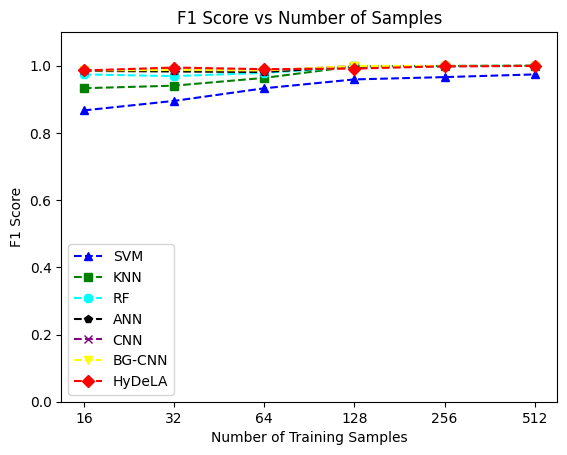

In [351]:
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_SVM, color='blue', marker='^', linewidth=1.5, markersize=6, linestyle = 'dashed')
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_KNN, color='green', marker='s', linewidth=1.5, markersize=6, linestyle = 'dashed')
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_RF, color='cyan', marker='8', linewidth=1.5, markersize=6, linestyle = 'dashed')
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_ANN, color='black', marker='p', linewidth=1.5, markersize=6, linestyle = 'dashed')
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_CNN, color='purple', marker='x', linewidth=1.5, markersize=6, linestyle = 'dashed')
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_BG, color='yellow', marker='v', linewidth=1.5, markersize=6, linestyle = 'dashed')
plt.plot([str(x) for x in [16, 32, 64, 128, 256, 512]], f1_HYDELA, color='red', marker='D', linewidth=1.5, markersize=6, linestyle = 'dashed')


plt.ylim([0,1.1])
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Samples')
# plt.grid(visible=True)
plt.legend(['SVM','KNN', 'RF', 'ANN', 'CNN','BG-CNN','HyDeLA'])
plt.show()

In [360]:
def fault_isolation(value):
  sit = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
  value_roc = []
  for i in range(len(y_test)):
    if value[i] in sit:
      value_roc.append(1)
    else:
      value_roc.append(0)

  return value_roc

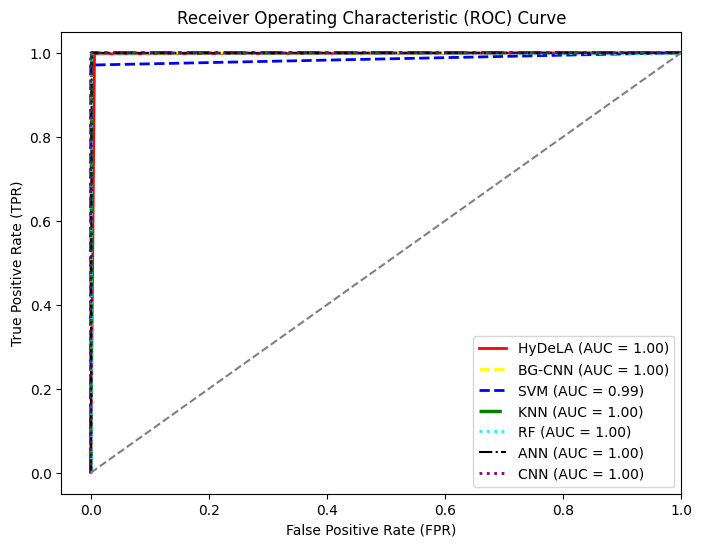

In [364]:
sit = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

test_roc = fault_isolation(y_test)


# Example: Actual and predicted values (replace with your own data)
fpr_svc, tpr_svc, threshold_svc = roc_curve(test_roc, fault_isolation(y_pred_svc))
fpr_knc, tpr_knc, threshold_knc = roc_curve(test_roc, fault_isolation(y_pred_knc))
fpr_rf, tpr_rf, threshold_rf = roc_curve(test_roc, fault_isolation(y_pred_rf))
fpr_ann, tpr_ann, threshold_ann = roc_curve(test_roc, fault_isolation(y_pred_ann))
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(test_roc, fault_isolation(y_pred_cnn))
fpr_bg, tpr_bg, threshold_bg = roc_curve(test_roc, fault_isolation(y_pred_bg))

roc_bg_auc = auc(fpr_bg, tpr_bg)
roc_svc_auc = auc(fpr_svc, tpr_svc)
roc_knc_auc = auc(fpr_knc, tpr_knc)
roc_rf_auc = auc(fpr_rf, tpr_rf)
roc_ann_auc = auc(fpr_ann, tpr_ann)
roc_cnn_auc = auc(fpr_cnn, tpr_cnn)


plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='red', lw=2, label=f"HyDeLA (AUC = {roc_auc:.2f})")
plt.plot(fpr_bg, tpr_bg, color='yellow', lw=2, label=f"BG-CNN (AUC = {roc_bg_auc:.2f})", linestyle='--')
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f"SVM (AUC = {roc_svc_auc:.2f})", linestyle='--')
plt.plot(fpr_knc, tpr_knc, color='green', lw=2.5, label=f"KNN (AUC = {roc_knc_auc:.2f})", linestyle='-.')
plt.plot(fpr_rf, tpr_rf, color='cyan', lw=2, label=f"RF (AUC = {roc_rf_auc:.2f})", linestyle=':')
plt.plot(fpr_ann, tpr_ann, color='black', lw=1.5, label=f"ANN (AUC = {roc_ann_auc:.2f})", linestyle='dashdot')
plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f"CNN (AUC = {roc_cnn_auc:.2f})", linestyle=':')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Ablation Results

The following code block has to be commented out before running the entire file. The necessary values are to be obtained by removing the corresponding components from the model architecture, executing the code and storing results. However, the presented version contains the results we obtained while doing ablation.

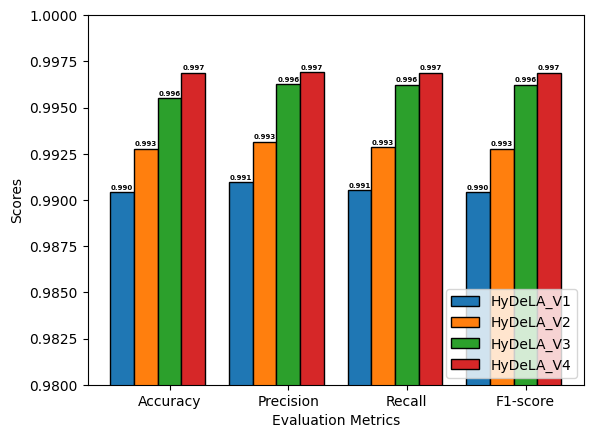

In [365]:
# Data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
HyDeLA_V1 = [0.9904296875, 0.9909474438519507, 0.9905290354865421, 0.9904296875]
HyDeLA_V2 = [0.9927734375, 0.9931388698220402, 0.992848195438128, 0.9927734375]
HyDeLA_V3 = [0.9955078125, 0.9962501925915113, 0.9962288096707737, 0.9962292609351433]
HyDeLA_V4 = [0.996875, 0.996896813610429, 0.9968784699814683, 0.996875]

# Set the width of the bars
width = 0.20

# Create subplots
fig, ax = plt.subplots()

# Plot the bars with black edges
ax.bar(np.arange(len(metrics)) - 2 * width, HyDeLA_V1, width, label='HyDeLA_V1', edgecolor='black')
ax.bar(np.arange(len(metrics)) - width, HyDeLA_V2, width, label='HyDeLA_V2', edgecolor='black')
ax.bar(np.arange(len(metrics)), HyDeLA_V3, width, label='HyDeLA_V3', edgecolor='black')
ax.bar(np.arange(len(metrics)) + width, HyDeLA_V4, width, label='HyDeLA_V4', edgecolor='black')

# Set x-axis labels and title
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
# ax.set_title('Model Performance Comparison')

# Add values on top of the bars with adjusted font size
for i in range(len(metrics)):
    ax.text(i - 2 * width, HyDeLA_V1[i] + 0.0001, f'{HyDeLA_V1[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')
    ax.text(i - width, HyDeLA_V2[i] + 0.0001, f'{HyDeLA_V2[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')
    ax.text(i, HyDeLA_V3[i] + 0.0001, f'{HyDeLA_V3[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')
    ax.text(i + width, HyDeLA_V4[i] + 0.0001, f'{HyDeLA_V4[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')

plt.ylim([0.980, 1.00])
# Add a legend
ax.legend(loc='lower right')

# Show the plot
plt.show()